<a href="https://colab.research.google.com/github/dgavieira/Chord-Recognition/blob/main/Chord_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas

In [2]:
!pip install matplotlib

In [3]:
!pip install seaborn

In [4]:
!pip install scipy

# Chord Classificator

This notebook aims to explore the intrisicates to classify western music chords using Machine Learning Techniques. The first section aims to detect, process and classify major chords from the major triads, as C, D, E, F, G, A and B. Furthermore, I will try to expand this processing for more complicated chord combinations.

First try:
* Major Triads

Furthermore:
* Minor Triads

Future tries:
* Tetrad chords (major and minor triads plus major or minor seventhies).
* Suspended Chords (tetrads without the third interval).
* Half Diminished Chords (Tetrads with the minor seventh and the perfect fifth).
* Full Diminished Chords (Tetrades with the  minor seventh and the flat fifth).
* Chord Inversions (Triads and Tetrads with the root not being the lowest note frequency-wise).

## Reference

This project is mainly based on a[ kaggle notebook from Ahmet Çelik. ](https://www.kaggle.com/code/ahmetcelik158/mathematics-of-music-chord-classification)

# 1. Understanding Math Behind Music



In [5]:
import os
import numpy as np
import IPython
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram, find_peaks

## 1.1 Generating the labelling for note frequencies

In [6]:
# Considering the hearing range from 20Hz to 20 kHz
# Starting with the note A from the 1st octave fA = 55 Hz (based on the central fA which is fA = 440 Hz)
# fA1 = fA5 /3 :

curr_freq = 55
freq_list = []

# Calculating 8 octaves of notes. Each octave has 12 notes considering western musical notation.
# Looping for 96 steps:
for i in range(96):
  freq_list.append(curr_freq)
  curr_freq *= np.power(2, 1/12)

# reshaping and create the notes dataframe
freq_array = np.reshape(np.round(freq_list, 1), (8, 12))
cols = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
df_note_freqs = pd.DataFrame(freq_array, columns=cols)
print("NOTE FREQUENCIES IN WESTERN MUSIC")
df_note_freqs.head(10)

NOTE FREQUENCIES IN WESTERN MUSIC


,A,A#,B,C,C#,D,D#,E,F,F#,G,G#
0,55.0,58.3,61.7,65.4,69.3,73.4,77.8,82.4,87.3,92.5,98.0,103.8
1,110.0,116.5,123.5,130.8,138.6,146.8,155.6,164.8,174.6,185.0,196.0,207.7
2,220.0,233.1,246.9,261.6,277.2,293.7,311.1,329.6,349.2,370.0,392.0,415.3
3,440.0,466.2,493.9,523.3,554.4,587.3,622.3,659.3,698.5,740.0,784.0,830.6
4,880.0,932.3,987.8,1046.5,1108.7,1174.7,1244.5,1318.5,1396.9,1480.0,1568.0,1661.2
5,1760.0,1864.7,1975.5,2093.0,2217.5,2349.3,2489.0,2637.0,2793.8,2960.0,3136.0,3322.4
6,3520.0,3729.3,3951.1,4186.0,4434.9,4698.6,4978.0,5274.0,5587.7,5919.9,6271.9,6644.9
7,7040.0,7458.6,7902.1,8372.0,8869.8,9397.3,9956.1,10548.1,11175.3,11839.8,12543.9,13289.8


In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
ROOT_DIR = '/content/drive/MyDrive/Datasets/chord-classification'

In [9]:
path_1 = ROOT_DIR + '/Audio_Files/Major/Major_0.wav'
path_2 = ROOT_DIR + '/Audio_Files/Minor/Minor_169.wav'
path_3 = ROOT_DIR + '/Audio_Files/Major/Major_111.wav'

In [10]:
IPython.display.Audio(path_1, rate = 44100)

In [11]:
IPython.display.Audio(path_2, rate = 44100)

In [12]:
IPython.display.Audio(path_3, rate = 44100)

## 1.2 Time and Frequency Domain Representations

In [13]:
freq = 220 # note frequency
fs = 44100 # sampling rate
duration = 1 # duration of a signal [seconds]
time = np.linspace(0, duration, fs*duration, endpoint=False)
# array for time stamps

# Creating signal in time domain
np.random.seed(42)
signal = np.zeros(len(time))
for i in range(1,12):
  amp = np.random.randint(0,10) # using random numbers for amplitudes
  current_freq = i*freq # current harmonic
  signal += amp*np.sin(2 * np.pi * current_freq * time)

# Fourier Transform
N = len(signal)
y_freq = fftfreq(N, 1/fs)[:N//2] # array for frequency stamps
signal_f = fft(signal) # Signal in frequency domain
signal_f_onesided = 2.0/N * np.abs(signal_f[0:N//2]) # taking positive terms

# Displaying audio
IPython.display.display(IPython.display.Audio(data=signal, rate=44100))

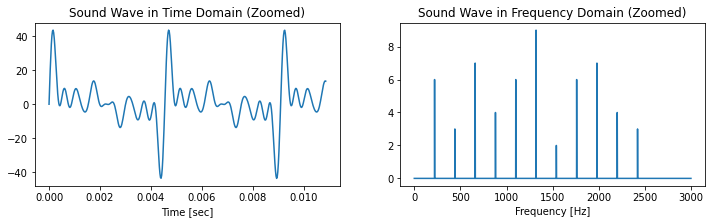

In [14]:
# Plotting signal in time and frequency domains
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(time[:480], signal[:480])
axes[0].set_title("Sound Wave in Time Domain (Zoomed)")
axes[0].set(xlabel='Time [sec]')
axes[1].plot(y_freq[:3000], signal_f_onesided[:3000])
axes[1].set_title("Sound Wave in Frequency Domain (Zoomed)")
axes[1].set(xlabel='Frequency [Hz]')
plt.show()

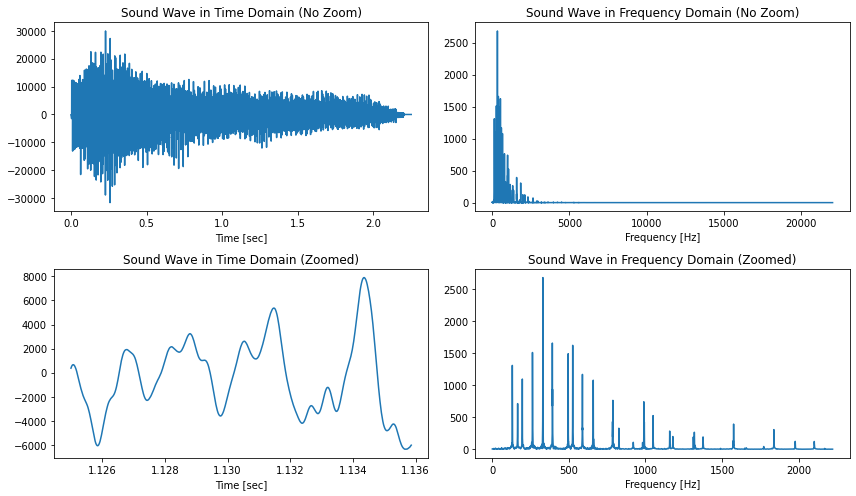

In [15]:
path = ROOT_DIR + '/Audio_Files/Major/Major_0.wav'
fs, signal = wavfile.read(path)
N = len(signal)
time = np.linspace(0., N/fs, N)

# Fourier Transform
y_freq = fftfreq(N, 1/fs)[:N//2]  # array for frequency stamps
signal_f = fft(signal) # Signal in frequency domain
signal_f_onesided = 2.0/N * np.abs(signal_f[0:N//2]) # taking positive terms

# Plotting signal in time and frequency domains
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes[0,0].plot(time, signal)
axes[0,0].set_title("Sound Wave in Time Domain (No Zoom)")
axes[0,0].set(xlabel='Time [sec]')
axes[0,1].plot(y_freq, signal_f_onesided)
axes[0,1].set_title("Sound Wave in Frequency Domain (No Zoom)")
axes[0,1].set(xlabel='Frequency [Hz]')
axes[1,0].plot(time[(N//2):(N//2+480)], signal[(N//2):(N//2+480)])
axes[1,0].set_title("Sound Wave in Time Domain (Zoomed)")
axes[1,0].set(xlabel='Time [sec]')
axes[1,1].plot(y_freq[:5000], signal_f_onesided[:5000])
axes[1,1].set_title("Sound Wave in Frequency Domain (Zoomed)")
axes[1,1].set(xlabel='Frequency [Hz]')
fig.tight_layout()
plt.show()

## 1.3 Spectrogram

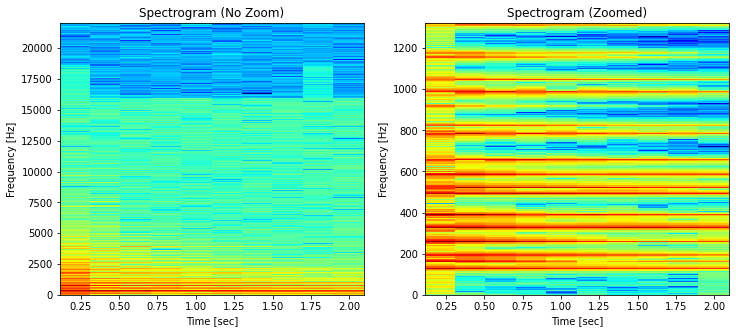

In [16]:
# applying spectrogram

f, t, Sxx = spectrogram(signal, fs, nperseg=10000, nfft = 50000)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].pcolormesh(t,f, np.log(Sxx), cmap="jet")
axes[0].set_title("Spectrogram (No Zoom)")
axes[0].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
axes[1].pcolormesh(t, f[:1500], np.log(Sxx)[:1500,:], cmap="jet")
axes[1].set_title("Spectrogram (Zoomed)")
axes[1].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
plt.show()

## 1.4 Detection of Harmonic Frequencies

Harmonics : [ 131.  165.  196.  262.  330.  392.  496.  525.  588.  659.  787.  826.
  989. 1050. 1158. 1179. 1312. 1319. 1376. 1576. 1838.]


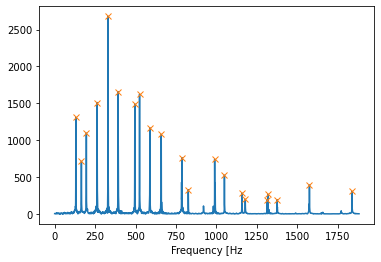

In [17]:
# h: height threshold. I defined as %4 of max value
h = signal_f_onesided.max()*0.05
peaks, _ = find_peaks(signal_f_onesided, distance=10, height = h)

freq_50_index = np.abs(y_freq - 50).argmin() # finding index for 50 Hz

peaks = peaks[peaks>freq_50_index]
harmonics = y_freq[peaks]
print("Harmonics : {}".format(np.round(harmonics)))

# Plot
i = peaks.max() + 100
plt.plot(y_freq[:i], signal_f_onesided[:i])
plt.plot(y_freq[peaks], signal_f_onesided[peaks], "x")
plt.xlabel("Frequency [Hz")
plt.show()

In [18]:
# I would like to create a method so that I can use in the next section
# The method will read sound file, apply Fourier, find peak frequencies and return
# Input: path of the sound file
# Output: Frequency peaks
# print_peaks = true to plot peaks

def find_harmonics(path, print_peaks=False):
    fs, X = wavfile.read(path)
    N = len(X)
    X_F = fft(X)
    X_F_onesided = 2.0/N * np.abs(X_F[0:N//2])
    freqs = fftfreq(N, 1/fs)[:N//2]
    freqs_50_index = np.abs(freqs - 50).argmin()
    
    h = X_F_onesided.max()*5/100
    peaks, _ = find_peaks(X_F_onesided, distance=10, height = h)
    peaks = peaks[peaks>freqs_50_index]
    harmonics = np.round(freqs[peaks],2)
    
    if print_peaks:
        i = peaks.max() + 100
        plt.plot(freqs[:i], X_F_onesided[:i])
        plt.plot(freqs[peaks], X_F_onesided[peaks], "x")
        plt.xlabel('Frequency [Hz]')
        plt.show()
    return harmonics

In [19]:
# Another Example to check if method is working correctly

path = ROOT_DIR + '/Audio_Files/Minor/Minor_169.wav'

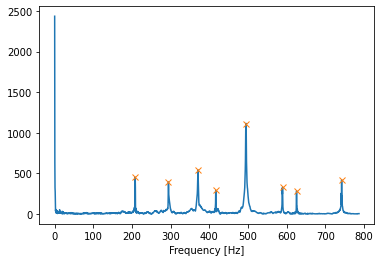

Harmonics: [208. 294. 370. 416. 494. 589. 625. 742.]


In [20]:
harmonics_2 = find_harmonics(path, print_peaks=True)
print("Harmonics: {}".format(np.round(harmonics_2)))

# 2. Importing Dataset

In [21]:
path = '/content/drive/MyDrive/Datasets/chord-classification/Audio_Files'
data = []
max_harm_length = 0 # I will keep track of max harmonic length for naming columns

for dirname, _, filenames in os.walk(path):
  for filename in filenames:
    foldername = os.path.basename(dirname)
    full_path = os.path.join(dirname, filename)
    freq_peaks = find_harmonics(full_path)

    max_harm_length = max(max_harm_length, len(freq_peaks))

    cur_data = [foldername, filename]
    cur_data.extend([freq_peaks.min(), freq_peaks.max(), len(freq_peaks)])
    cur_data.extend(freq_peaks)
    data.append(cur_data)

In [22]:
# Column Names for DataFrame:

cols = ['Chord Type', 'File Name', 'Min Harmonic', 'Max Harmonic', '# of Harmonics']

for i in range(max_harm_length):
  cols.append("Harmonic {}".format(i+1))

# Creating DataFrame
df = pd.DataFrame(data, columns=cols)
df.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Harmonic 29,Harmonic 30,Harmonic 31,Harmonic 32,Harmonic 33,Harmonic 34,Harmonic 35,Harmonic 36,Harmonic 37,Harmonic 38
0,Major,Major_10.wav,130.91,1408.64,20,130.91,185.00,234.09,262.27,329.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Major,Major_1.wav,131.11,993.33,16,131.11,165.33,174.67,196.44,261.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Major,Major_101.wav,155.91,1093.64,20,155.91,175.45,196.82,273.18,278.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Major,Major_0.wav,130.67,1838.22,21,130.67,165.33,196.00,262.22,330.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Major,Major_100.wav,155.45,2449.09,27,155.45,195.91,278.18,311.36,349.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. Data Exploration

In [23]:
df['Chord Type'].value_counts()

Major    502
Minor    357
Name: Chord Type, dtype: int64

## 3.1 Min and Max Harmonics

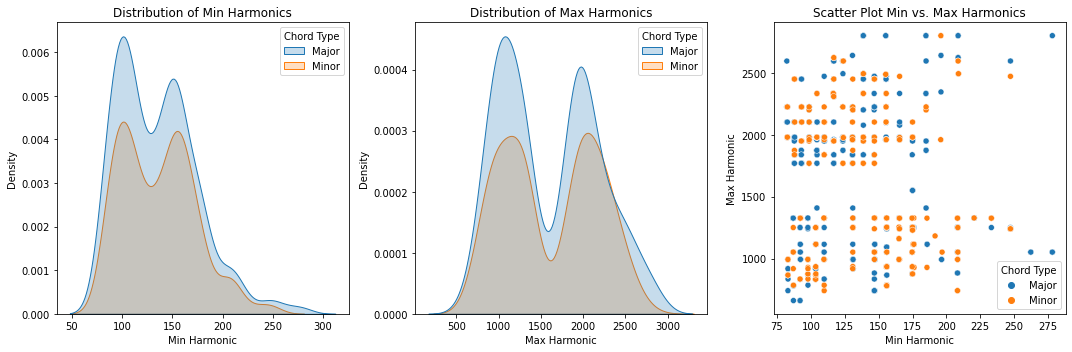

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(ax=axes[0], data=df, x="Min Harmonic", hue="Chord Type", shade=True)
sns.kdeplot(ax=axes[1], data=df, x="Max Harmonic", hue="Chord Type", shade=True)
sns.scatterplot(ax=axes[2], data=df, x="Min Harmonic", y="Max Harmonic",hue="Chord Type")
axes[0].set_title("Distribution of Min Harmonics")
axes[1].set_title("Distribution of Max Harmonics")
axes[2].set_title("Scatter Plot Min vs. Max Harmonics")
fig.tight_layout()
plt.show()

## 3.2 Number of Harmonics

In [26]:
df["# of Harmonics"].describe()

count    859.000000
mean      20.389988
std        6.656608
min        8.000000
25%       15.000000
50%       20.000000
75%       25.000000
max       38.000000
Name: # of Harmonics, dtype: float64

In [27]:
print("Number of Missing values:")
miss_values = df.isnull().sum().sort_values(ascending=False)
miss_values[miss_values>0]

Number of Missing values:


Harmonic 38    858
Harmonic 37    857
Harmonic 36    855
Harmonic 35    847
Harmonic 34    839
Harmonic 33    829
Harmonic 32    813
Harmonic 31    793
Harmonic 30    773
Harmonic 29    754
Harmonic 28    720
Harmonic 27    682
Harmonic 26    656
Harmonic 25    611
Harmonic 24    551
Harmonic 23    501
Harmonic 22    471
Harmonic 21    438
Harmonic 20    406
Harmonic 19    382
Harmonic 18    345
Harmonic 17    306
Harmonic 16    241
Harmonic 15    191
Harmonic 14    150
Harmonic 13    108
Harmonic 12     74
Harmonic 11     46
Harmonic 10     20
Harmonic 9      10
dtype: int64

## 3.3 Feature Engineering on Harmonics

In [28]:
df_original = df.copy()

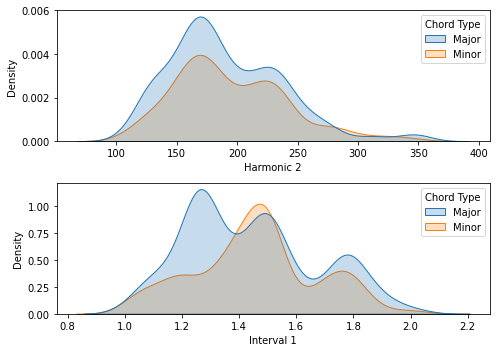

In [29]:
df["Interval 1"] = df["Harmonic 2"].div(df["Harmonic 1"], axis=0)

fig, axes = plt.subplots(2, 1, figsize=(7, 5))
sns.kdeplot(ax=axes[0], data=df, x="Harmonic 2", hue="Chord Type", shade=True)
sns.kdeplot(ax=axes[1], data=df, x="Interval 1", hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

In [30]:
df = df_original.copy() # refreshing df

for i in range(1,21):
    curr_interval = "Interval {}".format(i)
    curr_harm = "Harmonic {}".format(i+1)
    prev_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df[prev_harm], axis=0)
    
df.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Interval 11,Interval 12,Interval 13,Interval 14,Interval 15,Interval 16,Interval 17,Interval 18,Interval 19,Interval 20
0,Major,Major_10.wav,130.91,1408.64,20,130.91,185.00,234.09,262.27,329.55,...,1.054971,1.063154,1.176470,1.011280,1.055261,1.124936,1.053495,1.124803,1.067888,NaN
1,Major,Major_1.wav,131.11,993.33,16,131.11,165.33,174.67,196.44,261.78,...,1.125534,1.111533,1.008802,1.389790,1.080752,NaN,NaN,NaN,NaN,NaN
2,Major,Major_101.wav,155.91,1093.64,20,155.91,175.45,196.82,273.18,278.18,...,1.188654,1.191808,1.060464,1.057780,1.251999,1.069225,1.120785,1.124279,1.038861,NaN
3,Major,Major_0.wav,130.67,1838.22,21,130.67,165.33,196.00,262.22,330.22,...,1.049688,1.197417,1.061102,1.103298,1.017656,1.113492,1.005082,1.043128,1.145029,1.166709
4,Major,Major_100.wav,155.45,2449.09,27,155.45,195.91,278.18,311.36,349.55,...,1.113791,1.007590,1.064304,1.119760,1.122995,1.039390,1.019581,1.059233,1.059000,1.102333


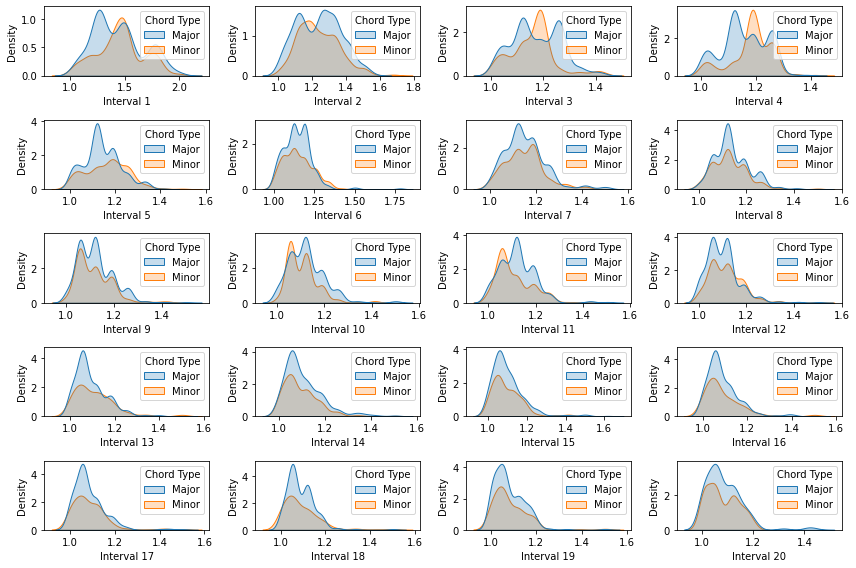

In [31]:
# Lets plot them
fig, axes = plt.subplots(5, 4, figsize=(12, 8))
for i in range(1,21):
    plt.subplot(5, 4, i)
    sns.kdeplot(data=df, x="Interval {}".format(i), hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

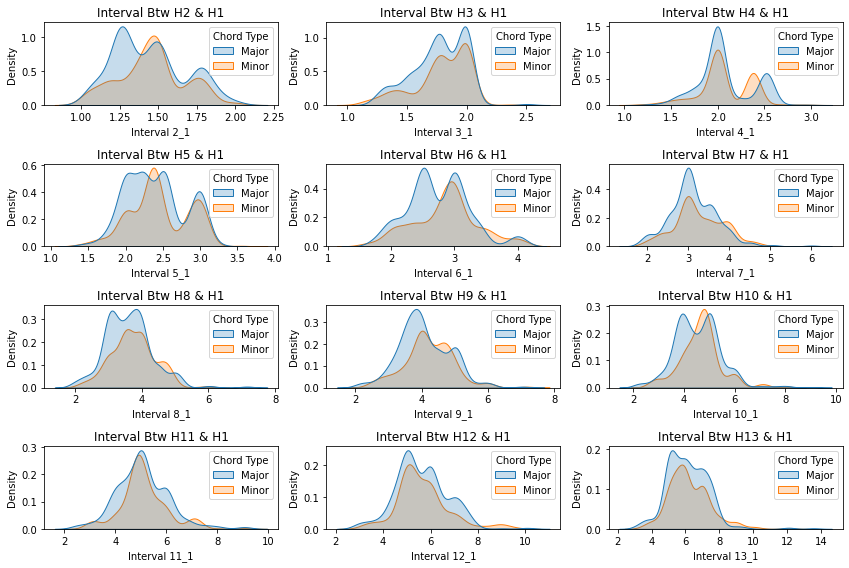

In [32]:
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
for i in range(2,14):
    curr_interval = "Interval {}_1".format(i)
    curr_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df["Harmonic 1"], axis=0)
    
    plt.subplot(4, 3, i-1)
    plt.gca().set_title("Interval Btw H{} & H1".format(i))
    sns.kdeplot(data=df, x=curr_interval, hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

# 4. Model Building